In [53]:
import warnings
warnings.filterwarnings('ignore')

In [54]:
import pandas as pd
import scanpy as sc
import plotnine as p9

import liana as li
import cell2cell as c2c
import decoupler as dc # needed for pathway enrichment

import numpy as np

from collections import defaultdict

import os
import sys

%matplotlib inline

## Root directory

In [55]:
os.chdir('/research/peer/fdeckert/FD20200109SPLENO')

## Settup rpy2 

In [56]:
os.environ['R_HOME'] = '/nobackup/peer/fdeckert/miniconda3/envs/r.4.4.1-FD20200109SPLENO/lib/R'

In [57]:
# import rpy2
# %load_ext rpy2.ipython

## Set parameter 

In [58]:
h5ad_file = 'data/scRNAseq/object/pp.h5ad'

In [59]:
sample_key = 'sample_rep' # Fake column 
condition_key = 'sample_group'
groupby = 'celltype_low'

celltype = ['MEP', 'Proerythroblast', 'Erythroblast', 'cMo', 'intMo', 'ncMo', 'RPM']
sample_group = ['IFNAR_fl_Baseline_D0', 'IFNAR_fl_LysM_cre_Baseline_D0', 'IFNAR_fl_CpG_D1', 'IFNAR_fl_LysM_cre_CpG_D1', 'IFNAR_fl_CpG_D3', 'IFNAR_fl_LysM_cre_CpG_D3']

# Prepare AnnData

In [60]:
adata = sc.read_h5ad(h5ad_file)

In [61]:
adata.obs['sample_rep'] = adata.obs['sample_group']

In [62]:
adata = adata[adata.obs.celltype_low.isin(celltype)]
adata = adata[adata.obs.facility=='VBC']
adata = adata[adata.obs.sample_group.isin(sample_group)]
adata = adata.copy()

In [63]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [64]:
cellchat_res = pd.read_csv('result/cci/lr_res.csv', index_col=0)
liana_res = cellchat_res.rename(columns={'prob': 'magnitude_rank', 'sample_group': 'sample_rep'})
liana_res = liana_res[liana_res['sample_rep'].isin(adata.obs.sample_group.to_list())]

In [65]:
adata.uns['liana_res'] = liana_res

In [66]:
tensor = li.multi.to_tensor_c2c(
    
    adata,
    sample_key=sample_key,
    score_key='magnitude_rank', # can be any score from liana
    how='outer_cells' # how to join the samples

)

100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


In [67]:
context_dict = adata.obs[[sample_key, condition_key]].drop_duplicates()
context_dict = dict(zip(context_dict[sample_key], context_dict[condition_key]))
context_dict = defaultdict(lambda: 'Unknown', context_dict)

tensor_meta = c2c.tensor.generate_tensor_metadata(
    
    interaction_tensor=tensor,
    metadata_dicts=[context_dict, None, None, None],
    fill_with_order_elements=True

)

In [68]:
tensor = c2c.analysis.run_tensor_cell2cell_pipeline(
    
    tensor,
    tensor_meta,
    copy_tensor=True, # Whether to output a new tensor or modifying the original
    rank=6, # Number of factors to perform the factorization. If None, it is automatically determined by an elbow analysis. Here, it was precomuputed.
    tf_optimization='regular', # To define how robust we want the analysis to be.
    random_state=0, # Random seed for reproducibility
    device='cpu', # Device to use. If using GPU and PyTorch, use 'cuda'. For CPU use 'cpu'
    elbow_metric='error', # Metric to use in the elbow analysis.
    smooth_elbow=False, # Whether smoothing the metric of the elbow analysis.
    upper_rank=20, # Max number of factors to try in the elbow analysis
    tf_init='random', # Initialization method of the tensor factorization
    tf_svd='numpy_svd', # Type of SVD to use if the initialization is 'svd'
    cmaps=None, # Color palettes to use in color each of the dimensions. Must be a list of palettes.
    sample_col='Element', # Columns containing the elements in the tensor metadata
    group_col='Category', # Columns containing the major groups in the tensor metadata
    output_fig=False, # Whether to output the figures. If False, figures won't be saved a files if a folder was passed in output_folder.

)

Running Tensor Factorization


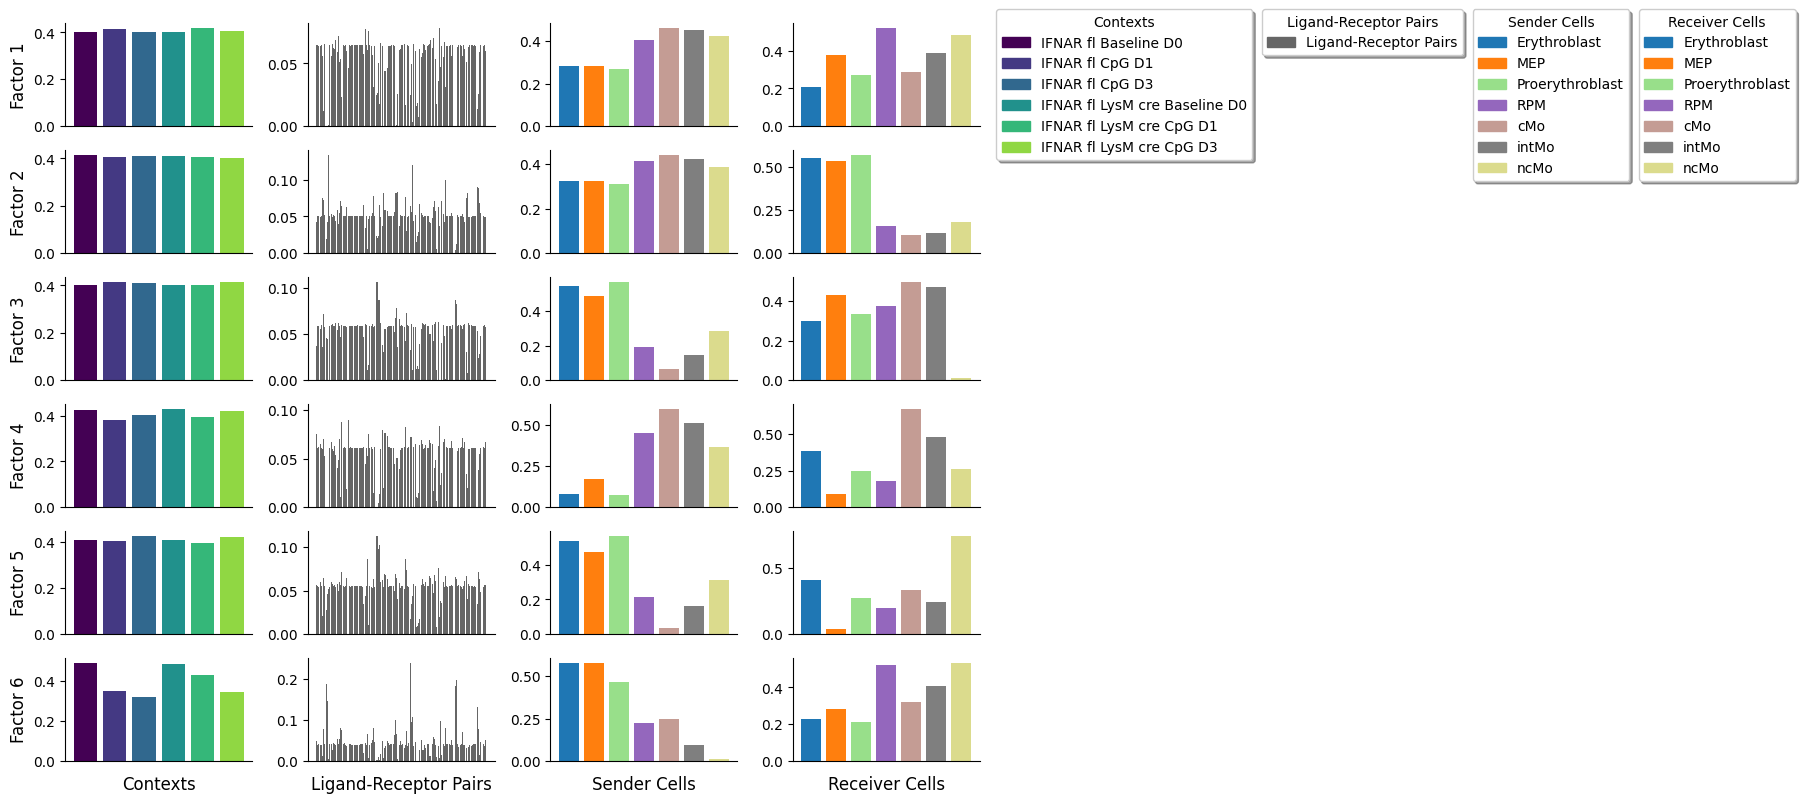

In [69]:
factors, axes = c2c.plotting.tensor_factors_plot(
    
    interaction_tensor=tensor,
    metadata = tensor_meta, # This is the metadata for each dimension
    sample_col='Element',
    group_col='Category',
    meta_cmaps = ['viridis', 'Dark2_r', 'tab20', 'tab20'],
    fontsize=10, # Font size of the figures generated
    
)

In [70]:
factors = tensor.factors

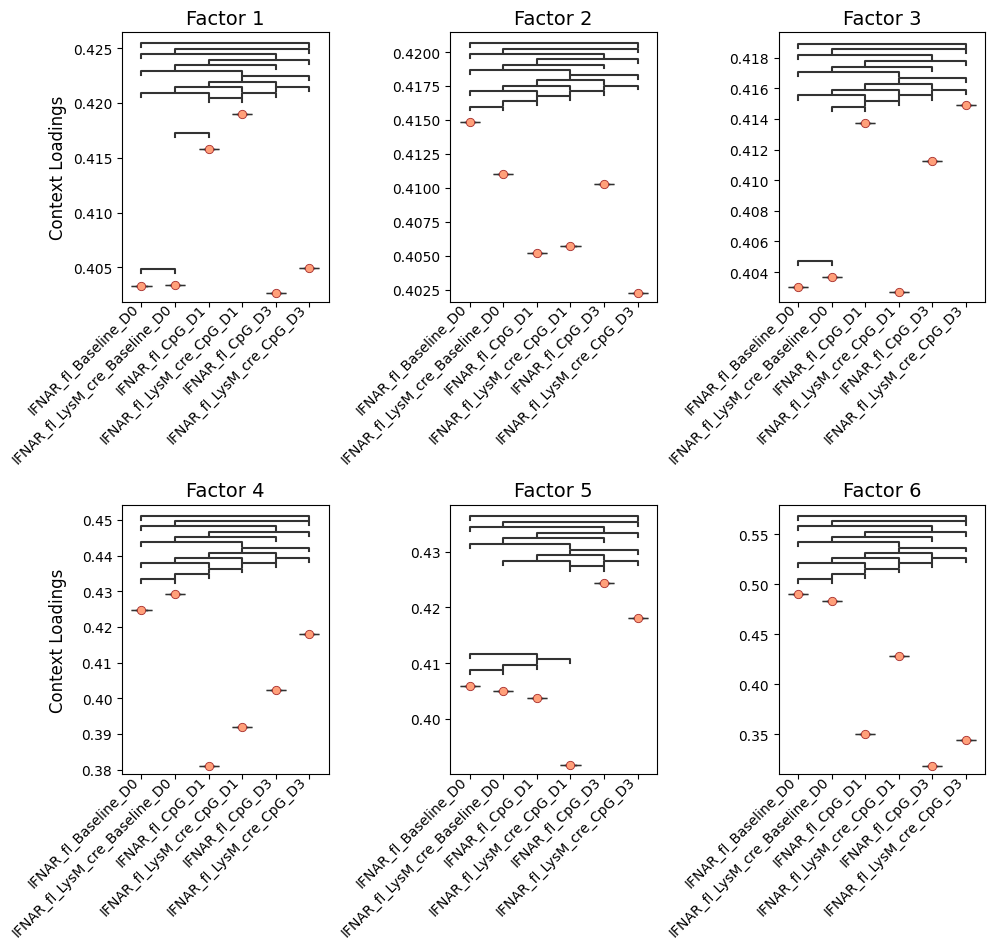

In [71]:
catch = c2c.plotting.context_boxplot(
    
    context_loadings=factors['Contexts'],
    metadict=context_dict,
    nrows=2,
    figsize=(10, 10),
    statistical_test='t-test_ind',
    pval_correction='fdr_bh',
    cmap='plasma',
    verbose=False, 
    group_order=sample_group

)

In [72]:
lr_loadings = factors['Ligand-Receptor Pairs']

In [73]:
# Store factors
factors['Ligand-Receptor Pairs'].to_csv('result/cci//factors.csv')

In [74]:
# load PROGENy pathways
net = dc.get_progeny(organism='mouse')

In [75]:
# load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('mouseconsensus')

In [76]:
# generate ligand-receptor geneset
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, net, lr_sep="^")

In [77]:
# run enrichment analysis
estimate, pvals = dc.run_ulm(lr_loadings.transpose(), lr_progeny, source="source", target="interaction", use_raw=False)

In [78]:
# dc.plot_barplot(estimate, 'Factor 1', vertical=True, cmap='coolwarm', vmin=-7, vmax=7)